
# Week 3: Exploring Overfitting in NLP

Welcome to this assignment! During this week you saw different ways to handle sequence-like data. You saw how some Keras' layers such as `GRU`, `Conv` and `LSTM` can be used to tackle problems in this space. Now you will put this knowledge into practice by creating a model architecture that does not overfit.

For this assignment you will be using a variation of the [Sentiment140 dataset](https://www.tensorflow.org/datasets/catalog/sentiment140), which contains 1.6 million tweets alongside their respective sentiment (0 for negative and 4 for positive). **This variation contains only 160 thousand tweets.**

You will also need to create the helper functions very similar to the ones you coded in previous assignments pre-process data and to tokenize sentences. However the objective of the assignment is to find a model architecture that will not overfit.

Let's get started!

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.


- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.
- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!
- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.
- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# import unittests

## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAX_LENGTH`: Maximum length of all sequences. Defaults to 32.

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9

- `NUM_BATCHES`: Number of batches. Defaults to 128

    
**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**

In [2]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

## Explore the dataset

The dataset is provided in a csv file. 

Each row of this file contains the following values separated by commas:

- target: the polarity of the tweet (0 = negative, 4 = positive)

- ids: The id of the tweet

- date: the date of the tweet

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: the user that tweeted

- text: the text of the tweet


Take a look at the first five rows of this dataset.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [19]:
data_path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(data_path, header=None,encoding='utf-8',encoding_errors='ignore')
#shuffle the original dataset 
df = df.sample(frac=1, random_state=58).reset_index(drop=True)
df.head()

,0,1,2,3,4,5
0,4,2056207309,Sat Jun 06 10:43:19 PDT 2009,NO_QUERY,Rhi_Louise,@cockneycomic your no use! lol
1,4,1974427943,Sat May 30 13:06:58 PDT 2009,NO_QUERY,NMMNGFRANK,"THANK YOU! THANK YOU! THANK YOU, FOR ALL THE B..."
2,0,1550773460,Sat Apr 18 07:13:48 PDT 2009,NO_QUERY,TidyCat,looks like another beautiful day here today - ...
3,0,2191507642,Tue Jun 16 05:25:17 PDT 2009,NO_QUERY,absalomedia,Business phone keeps on dying. Ordered Iphone...
4,4,2017267359,Wed Jun 03 08:07:07 PDT 2009,NO_QUERY,shy_matsi,@KookyFox fox tongue bathing action! I can fil...


Looking at the contents of the csv file by using pandas is a great way of checking how the data looks like. Now you need to create a `tf.data.Dataset` with the corresponding text and sentiment for each tweet:

In [20]:
# Standardize labels so they have 0 for negative and 1 for positive
labels = df[0].apply(lambda x: 0 if x == 0 else 1).to_numpy()

# Since the original dataset does not provide headers you need to index the columns by their index
sentences = df[5].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 1600000 examples

Text of second example look like this: THANK YOU! THANK YOU! THANK YOU, FOR ALL THE BDAY LOVE 

Labels of first 5 examples look like this: [1, 1, 0, 0, 1]


## Exercise 1: train_val_datasets

Now you will code the `train_val_datasets` function, which given the full tensorflow dataset, shuffles it and splits the dataset into two, one for training and the other one for validation taking into account the `TRAINING_SPLIT` defined earlier. It should also batch the dataset so that it is arranged into `NUM_BATCHES` batches.

In the previous week you created this split between training and validation by manipulating numpy arrays but this time the data already comes encoded as `tf.data.Dataset`s. This is so you are comfortable manipulating this kind of data regardless of the format.

**Hints:**


- Take a look at the [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) and [skip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) methods to generate the training and validation data.


- The [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method is useful to split the dataset into the desired number of batches.


In [23]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets(dataset):
    """
    Splits the dataset into training and validation sets, after shuffling it.
    
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with elements as (sentence, label)
    
    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    """   
    ### START CODE HERE ###
    
    # Compute the number of sentences that will be used for training (should be an integer)
    
    #orginal data has too many data,shrinken to 10%
    #orginal data has too many data,shrinken to 10%
    #orginal data has too many data,shrinken to 10%
    # train_size = int (len(dataset) * TRAINING_SPLIT)
    

    # Split the sentences and labels into train/validation splits

    #orginal data has too many data,shrinken to 10%
    # train_dataset = dataset.take(train_size)
    # validation_dataset = dataset.skip(train_size)
    train_dataset = dataset.take(144000)
    validation_dataset = dataset.skip(1584000)

    # Turn the dataset into a batched dataset with num_batches batches
    train_dataset = train_dataset.batch(NUM_BATCHES)
    validation_dataset = validation_dataset.batch(NUM_BATCHES)

    ### END CODE HERE ###
    
    return train_dataset, validation_dataset

In [24]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {NUM_BATCHES*len(validation_dataset)} elements for validation.\n")

There are 1125 batches for a total of 144000 elements for training.

There are 125 batches for a total of 16000 elements for validation.



***Expected Output:***

```
There are 1125 batches for a total of 144000 elements for training.

There are 125 batches for a total of 16000 elements for validation.

```

In [ ]:
# Test your code!
# unittests.test_train_val_datasets(train_val_datasets)

## Exercise 2: fit_vectorizer

Now that you have batched datasets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_vectorizer` function below. This function should return a [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer that has been fitted to the training sentences.


**Hints:**


- This time you didn't define a custom `standardize_func` but you should convert to lower-case and strip punctuation out of the texts. For this check the different options for the [`standardize`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#args) argument of the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer.


- The texts should be truncated so that the maximum length is equal to the `MAX_LENGTH` defined earlier. Once again check the [`docs`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#args) for an argument that can help you with this.

- You should NOT predefine a vocabulary size but let the layer learn it from the sentences.

In [25]:
# GRADED FUNCTION: fit_vectorizer

def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences
    
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.
    
    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """    

    ### START CODE HERE ###
    
    # Instantiate the TextVectorization class, defining the necessary arguments alongside their corresponding values
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',  
        output_sequence_length = MAX_LENGTH
    ) 
    
    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)
    
    ### END CODE HERE ###
    
    return vectorizer

In [26]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 145652 words



***Expected Output:***

```
Vocabulary contains 145856 words

```

In [ ]:
# Test your code!
# unittests.test_fit_vectorizer(fit_vectorizer)

**This time you don't need to encode the labels since these are already encoded as 0 for negative and 1 for positive**. But you still need to apply the vectorization to the texts of the dataset using the adapted vectorizer you've just built. You can do so by running the following cell:

In [27]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

### Using pre-defined Embeddings

This time you will not be learning embeddings from your data but you will be using pre-trained word vectors. In particular you will be using the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [28]:
# Define path to file containing the embeddings
# glove_file = './data/glove.6B.100d.txt'

glove_file = '/kaggle/input/100-dimension-glove/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

Now you have access to GloVe's pre-trained word vectors. Isn't that cool?

Let's take a look at the vector for the word **dog**:

In [29]:
test_word = 'dog'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

Feel free to change the `test_word` to see the vector representation of any word you can think of.

Also, notice that the dimension of each vector is 100. You can easily double check this by running the following cell:

In [30]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


Now you can represent the words in your vocabulary using the embeddings. To do this, save the vector representation of each word in the vocabulary in a numpy array.

A couple of things to notice:
- You need to build a `word_index` dictionary where it stores the encoding for each word in the adapted vectorizer.

- If a word in your vocabulary is not present in `GLOVE_EMBEDDINGS` the representation for that word is left as a column of zeros.

In [31]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

print(f"The word dog is encoded as: {word_index['dog']}")

The word dog is encoded as: 533


In [32]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

As a sanity check, make sure that the vector representation for the word `dog` matches the column of its index in the `EMBEDDINGS_MATRIX`:

In [33]:
test_word = 'dog'

test_word_id = word_index[test_word]

test_vector_dog = glove_embeddings[test_word]

test_embedding_dog = embeddings_matrix[test_word_id]

both_equal = np.allclose(test_vector_dog,test_embedding_dog)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: dog, index: 533

Embedding is equal to column 533 in the embeddings_matrix: True


Now you have the pre-trained embeddings ready to use!

## Exercise 3: create_model

Now you need to define a model that will handle the problem at hand while not overfitting.

**Hints**:

- The layer immediately after `tf.keras.Input` should be a `tf.keras.layers.Embedding`. The parameter that configures the usage of the pre-trained embeddings is already provided but you still need to fill the other ones.

- There multiple ways of solving this problem. So try an architecture that you think will not overfit.


- You can try different combinations of layers covered in previous ungraded labs such as:
    - `Conv1D`
    - `Dropout`
    - `GlobalMaxPooling1D`    
    - `MaxPooling1D`    
    - `LSTM`    
    - `Bidirectional(LSTM)`


- Include at least one `Dropout` layer to mitigate overfitting.


- The last two layers should be `Dense` layers.


- Try simpler architectures first to avoid long training times. Architectures that are able to solve this problem usually have around 3-4 layers (excluding the last two `Dense` ones). 


In [38]:
# GRADED FUNCTION: create_model

def create_model(vocab_size, pretrained_embeddings):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): Number of words in the vocabulary.
        pretrained_embeddings (np.ndarray): Array containing pre-trained embeddings.

    Returns:
        (tf.keras Model): the sentiment classifier model
    """
    ### START CODE HERE ###
    
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape = ((None,))),
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[pretrained_embeddings],trainable=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile( 
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'] 
    ) 

    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.
- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.


**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [39]:
# Create your untrained model
model = create_model(vocab_size, embeddings_matrix)

# Check parameter count against a reference solution
# unittests.parameter_count(model)

In [40]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 1)


**Expected Output:**
```
predictions have shape: (NUM_BATCHES, n_units)
```

Where `NUM_BATCHES` is the globally defined variable and `n_units` is the number of units of the last layer of your model.

In [ ]:
# Test your code!
# unittests.test_create_model(create_model)

In [41]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized, 
	epochs=20, 
	validation_data=validation_dataset_vectorized
)

Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6799 - loss: 0.5901 - val_accuracy: 0.7607 - val_loss: 0.4914
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.7452 - loss: 0.5112 - val_accuracy: 0.7753 - val_loss: 0.4706
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7628 - loss: 0.4889 - val_accuracy: 0.7825 - val_loss: 0.4609
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.7686 - loss: 0.4763 - val_accuracy: 0.7815 - val_loss: 0.4599
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7762 - loss: 0.4671 - val_accuracy: 0.7869 - val_loss: 0.4552
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.7801 - loss: 0.4598 - val_accuracy: 0.7865 - val_loss: 0.4542
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7851 - loss: 0.4529 - val_accuracy: 0.7894 - val_loss: 0.4501
Epoch 8/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7878 -

**To pass this assignment your `val_loss` (validation loss) should either be flat or decreasing.** 

Although a flat `val_loss` and a lowering `train_loss` (or just `loss`) also indicate some overfitting what you really want to avoid is having a lowering `train_loss` and an increasing `val_loss`.

With this in mind, the following three curves will be acceptable solutions:

<table><tr><td><img src='images/valid-1.png'></td><td><img src='images/valid-2.jpg'></td><td><img src='images/valid-3.jpg'></td></tr></table>

While the following would not be able to pass the grading:

<table><tr><td><img src='images/invalid-1.jpg'></td></tr></table>

Run the next block of code to plot the metrics. 

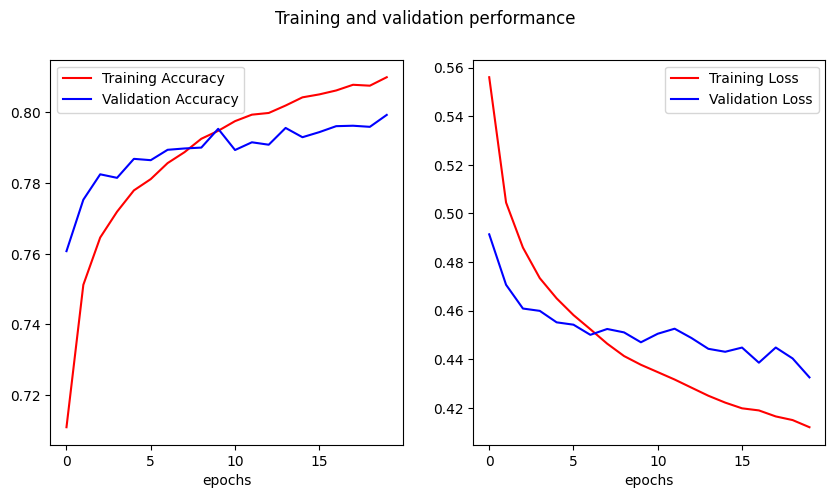

In [42]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

A more rigorous way of setting the passing threshold of this assignment is to use the slope of your `val_loss` curve.

**To pass this assignment the slope of your `val_loss` curve should be 0.0005 at maximum.** You can test this by running the next cell:

In [ ]:
# Test your code!
# unittests.test_history(history)

**If your model generated a validation loss curve that meets the criteria above, run the following cell and then submit your assignment for grading. Otherwise, try with a different architecture.**

In [43]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying sentiment in text data while doing a fairly good job of not overfitting! Nice job!

**Keep it up!**